# 14. Modelo hibrido CNN-LSTM clasificacion binaria
***

### Caso de estudio #1


### Tecnicas de ajuste de los datos y modelos:

| Ingeniería de datos       | Si / No       |
| :-------                  | :------:    |
| Escalado de datos         | Si          |
| Ajuste de arquitectura         | Si          |
| Ajuste de filtros            | Si          |
| Ajuste tañaño de kernel | Si          |
| Regularizacion  | Si          |
| Ajuste de pesos  | Si          |
| Sobremuestreo  | No        |

In [1]:
# librerias
import numpy as np
import math
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import seaborn as sns


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix,accuracy_score
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import make_scorer, accuracy_score
from plot_metric.functions import BinaryClassification
from sklearn.metrics import classification_report
from sklearn import preprocessing

import os
import h5py
from sklearn import datasets 
from keras.models import model_from_json

from numba import cuda
from pandas import DataFrame
from numpy import array
from matplotlib import pyplot

from numpy import mean
from numpy import std
from numpy import dstack



Using TensorFlow backend.


In [2]:
# BINARIA funcion para generar matriz de confusion y medidas de desempeño del modelos clasificacion binarios
def model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
   # Medidas de desempeño del modelo
    matriz = confusion_matrix(label_test, label_pred)
    print('Confusion Matrix: \n',confusion_matrix(label_test,label_pred))
    print('\n')
    print("MEDIDAS DE DESEMPEÑO DEL MODELO")
    print('\n')
    print('Exactitud - Accuracy: {}'.format(accuracy_score(label_test,label_pred)))
    print('ROC AUC: {}'.format (metrics.roc_auc_score(label_test, label_pred)))
    print('-'*60)
    print('Precisión por clase: {}'.format(metrics.precision_score(label_test, label_pred, average=None)))
    print('Sensibilidad - Recall por clase: {}'.format(metrics.recall_score(label_test, label_pred, average=None)))
    print('F1 por clase: {}'.format(metrics.f1_score(label_test, label_pred, average=None)))
    print('-'*60)
    print('F1 Macro: {}'.format(metrics.f1_score(label_test, label_pred, average='macro')))
    print('F1 Micro: {}'.format(metrics.f1_score(label_test, label_pred, average='micro')))
    print('F1 Weighted: {}'.format(metrics.f1_score(label_test, label_pred, average='weighted')))
    print('-'*60)
    print('Sensibilidad - Recall Macro: {}'.format(metrics.recall_score(label_test, label_pred, average='macro')))
    print('Sensibilidad - Recall Micro: {}'.format(metrics.recall_score(label_test, label_pred, average='micro')))
    print('Sensibilidad - Recall Weighted: {}'.format(metrics.recall_score(label_test, label_pred, average='weighted')))
    print('-'*60)
    print('Precisión Macro: {}'.format(metrics.precision_score(label_test, label_pred, average='macro')))
    print('Precisión Micro: {}'.format(metrics.precision_score(label_test, label_pred, average='micro')))
    print('Precisión Weighted: {}'.format(metrics.precision_score(label_test, label_pred, average='weighted')))
   
    TP = matriz[1][1]
    TN = matriz[0][0]
    FP = matriz[0][1]
    FN = matriz[1][0]
    print('-'*60)
    print('Verdaderos positivos - True Positives:', TP)
    print('Verdaderos negativos - True Negatives:', TN)
    print('Falsos positivos - False Positives:', FP)
    print('Falsos negativos - False Negatives:', FN)
        # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
        # calculate mis-classification
    conf_misclassification = 1- conf_accuracy
        # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
        # calculate the specificity
    conf_specificity = (TN / float(TN + FN))
        # calculate precision
    conf_precision = (TP / float(TP + FP))
        # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
        # calculate FPR tasa de falsos positivos
    conf_FPR = 1 - conf_specificity
    print('-'*60)
    print(f'Error de clasificacion: {round(conf_misclassification,3)}') 
    print(f'Especificidad - Specificity: {round(conf_specificity,3)}') 
    print(f'Tasa de falsos positivos FPR: {round(conf_FPR,3)}')
    print('-'*60)
    print(classification_report(label_test, label_pred))
    # curva ROC clasificacion binaria
    bc = BinaryClassification(label_test, label_pred, labels=["Class 0", "Class 1"])
    plt.figure(figsize=(5,5))
    bc.plot_roc_curve()
    print('\n')
    print("CURVA ROC")
    plt.show()

In [3]:
# grtafica de perdida y precision 
def history_plot(hist1, hist2, title, ylabl, xlabl):
    fig_acc = plt.figure(figsize=(12,4))
    plt.plot(history.history[hist1])
    plt.plot(history.history[hist2])
    plt.title(title)
    plt.ylabel(ylabl)
    plt.xlabel(xlabl)
    plt.legend(['train', 'validation'], loc='upper left')
    return plt

### Preparar datos

In [4]:
columns=["id","ciclo","set1","set2","set3","sensor1","sensor2","sensor3","sensor4","sensor5","sensor6","sensor7","sensor8",
         "sensor9","sensor10","sensor11","sensor12","sensor13","sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
         ,"sensor20","sensor21","sensor22","sensor23"]
train=pd.read_csv("train_FD001.txt",sep=" ",names=columns)
test=pd.read_csv("test_FD001.txt",sep=" ",names=columns)
rul=pd.read_csv("RUL_FD001.txt",sep=" ",header=None)
train.drop(['sensor22','sensor23'], axis=1, inplace=True)
test.drop(['sensor22','sensor23'], axis=1, inplace=True)
rul.drop([1], axis=1, inplace=True)
rul.columns = ['ttf']
rul2=pd.DataFrame(train.groupby('id')['ciclo'].max()).reset_index()
rul2.columns = ['id', 'falla']
train= train.merge(rul2, on=['id'], how='left')
train['ttf'] = train['falla'] - train['ciclo']
train.drop('falla', axis=1, inplace=True)
train['clase1']=np.where(train['ttf'] <= 30, 1, 0)
train.head()


,id,ciclo,set1,set2,set3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,ttf,clase1
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0


In [5]:
rul3=pd.DataFrame(test.groupby('id')['ciclo'].max()).reset_index()
rul3.columns = ['id', 'falla']
rul['id'] = rul.index + 1
rul['falla'] = rul3['falla'] + rul['ttf']
rul.drop('ttf', axis=1, inplace=True)
test=test.merge(rul, on=['id'], how='left')
test['ttf'] = test['falla'] - test['ciclo']
test.drop('falla', axis=1, inplace=True)
test['clase1']=np.where(test['ttf'] <= 30, 1, 0)
test.head()


,id,ciclo,set1,set2,set3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,ttf,clase1
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142,0
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141,0
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140,0
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139,0
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138,0


In [6]:
variables=['set1','set2','set3','sensor1','sensor2','sensor3','sensor4','sensor5','sensor6','sensor7','sensor8','sensor9','sensor10','sensor11','sensor12','sensor13','sensor14','sensor15','sensor16','sensor17','sensor18','sensor19','sensor20','sensor21']
objetivo='clase1'
# escalado de datos sin incluir id, ciclo, ttf y clase
scaler = MinMaxScaler()
train[variables]=scaler.fit_transform(train[variables])
test[variables]=scaler.transform(test[variables])
train.head()

,id,ciclo,set1,set2,set3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,ttf,clase1
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0


In [7]:
test.head()

,id,ciclo,set1,set2,set3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,ttf,clase1
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,142,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,141,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,140,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,139,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,138,0


In [8]:
print("numero de dimensiones =", train.ndim)
print("tamaño de la tabla =", train.shape)
print("total datos =", train.size)

numero de dimensiones = 2
tamaño de la tabla = (20631, 28)
total datos = 577668


In [9]:
print("numero de dimensiones =", test.ndim)
print("tamaño de la tabla =", test.shape)
print("total datos =", test.size)

numero de dimensiones = 2
tamaño de la tabla = (13096, 28)
total datos = 366688


In [10]:
# funcionar para adaptar datos como lo requiere LSTM
def gen_sequence(id_df, seq_length, seq_cols):
    df_zeros=pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    id_df=df_zeros.append(id_df,ignore_index=True)
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        lstm_array.append(data_array[start:stop, :])
    return np.array(lstm_array)


def gen_label(id_df, seq_length, seq_cols,label):
    df_zeros=pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    id_df=df_zeros.append(id_df,ignore_index=True)
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    y_label=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        y_label.append(id_df[label][stop])
    return np.array(y_label)

In [11]:
pasos_de_tiempo=40
columnas_secuencia=variables


data_train=np.concatenate(list(list(gen_sequence(train[train['id']==id], pasos_de_tiempo, columnas_secuencia)) for id in train['id'].unique()))

label_train=np.concatenate(list(list(gen_label(train[train['id']==id], pasos_de_tiempo, columnas_secuencia,'clase1')) for id in train['id'].unique()))


data_test=np.concatenate(list(list(gen_sequence(test[test['id']==id], pasos_de_tiempo, columnas_secuencia)) for id in test['id'].unique()))

label_test=np.concatenate(list(list(gen_label(test[test['id']==id], pasos_de_tiempo, columnas_secuencia,'clase1')) for id in test['id'].unique()))


In [12]:
print("numero de dimensiones Data_train =", data_train.ndim)
print("tamaño de la tabla Data_train =", data_train.shape)
print("total datos Data_train =", data_train.size)
print('-'*60)
print("numero de dimensiones Label_train =", label_train.ndim)
print("tamaño de la tabla Label_train =", label_train.shape)
print("total datos Label_train =", label_train.size)
print('-'*60)
print("numero de dimensiones Data_test =", data_test.ndim)
print("tamaño de la tabla Data_test =", data_test.shape)
print("total datos Data_test =", data_test.size)
print('-'*60)
print("numero de dimensiones Label_test =", label_test.ndim)
print("tamaño de la tabla Label_test =", label_test.shape)
print("total datos Label_test =", label_test.size)


numero de dimensiones Data_train = 3
tamaño de la tabla Data_train = (20531, 40, 24)
total datos Data_train = 19709760
------------------------------------------------------------
numero de dimensiones Label_train = 1
tamaño de la tabla Label_train = (20531,)
total datos Label_train = 20531
------------------------------------------------------------
numero de dimensiones Data_test = 3
tamaño de la tabla Data_test = (12996, 40, 24)
total datos Data_test = 12476160
------------------------------------------------------------
numero de dimensiones Label_test = 1
tamaño de la tabla Label_test = (12996,)
total datos Label_test = 12996


### Transformar datos para la capa del modelo convolucional 1D

In [13]:
# reshape datos en pasos de tiempo y sub-secuencias

n_steps, n_length = 4, 10
data_train = data_train.reshape((data_train.shape[0], n_steps, n_length, data_train.shape[2]))
data_test = data_test.reshape((data_test.shape[0], n_steps, n_length, data_test.shape[2]))

print("numero de dimensiones Data_train =", data_train.ndim)
print("tamaño de la tabla Data_train =", data_train.shape)
print("total datos Data_train =", data_train.size)
print('-'*60)
print("numero de dimensiones Data_test =", data_test.ndim)
print("tamaño de la tabla Data_test =", data_test.shape)
print("total datos Data_test =", data_test.size)


numero de dimensiones Data_train = 4
tamaño de la tabla Data_train = (20531, 4, 10, 24)
total datos Data_train = 19709760
------------------------------------------------------------
numero de dimensiones Data_test = 4
tamaño de la tabla Data_test = (12996, 4, 10, 24)
total datos Data_test = 12476160


## Prueba modelo CNN-LSTM con 5 repeticiones para evaluar exactitud 

In [20]:
# ajustar y evaluar modelo
def evaluate_model(data_train, label_train, data_test, label_test):
    # definir parametros
    verbose, epochs, batch_size = 0, 20, 32
    n_steps=data_train.shape[1]
    n_length= data_train.shape[2]
    n_features =data_train.shape[3]
    n_outputs= 1
    # definir el modelo
    model = Sequential()
    model.add(TimeDistributed(Conv1D(256, 3, activation='relu'), input_shape=(None,n_length,n_features)))
    model.add(TimeDistributed(Conv1D(256, 3, activation='relu')))
    model.add(TimeDistributed(Dropout(0.4)))
    model.add(TimeDistributed(MaxPooling1D()))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(100))
    model.add(Dropout(0.4))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # entrenar la red
    model.fit(data_train, label_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluar la exactitud
    _, accuracy = model.evaluate(data_test, label_test, batch_size=batch_size, verbose=0)
    return accuracy

# resumen de resultados
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

# correr multiples experimentos
def run_experiment(repeats=5):
    # repetir experimentos
    scores = list()
    for r in range(repeats):
        score = evaluate_model(data_train, label_train, data_test, label_test)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
    # resumir resultados
    summarize_results(scores)

# correr la prueba
run_experiment()

>#1: 98.961
>#2: 99.000
>#3: 98.646
>#4: 99.023
>#5: 98.792
[98.9612188365651, 98.9996922129886, 98.64573714989227, 99.02277623884272, 98.79193598030163]
Accuracy: 98.884% (+/-0.144)


Se obtiene una exactitud media de 99.884% con una desviacion estandar de 0.144%, lo que evidencia que no hay una variacion significativa cuando se ejecuta el mismo modelo varias veces

## Evaluacion y ajuste de arquitectura hibrida optima CNN-LSTM

In [14]:
model_path_clf = 'classification_model.h5'  

# model
verbose, epochs, batch_size = 0, 50, 32
n_steps=data_train.shape[1]
n_length= data_train.shape[2]
n_features =data_train.shape[3]
n_outputs= 1

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(256, 3, activation='relu'), input_shape=(None,n_length,n_features)))
model.add(TimeDistributed(Conv1D(256, 3, activation='relu')))
model.add(TimeDistributed(Dropout(0.2)))
model.add(TimeDistributed(MaxPooling1D()))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dense(n_outputs, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# fit network

history = model.fit(data_train, label_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=2, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path_clf, monitor='val_loss', save_best_only=True, mode='min', verbose=2)])
print(history.history.keys())







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, None, 8, 256)      18688     
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 6, 256)      196864    
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 6, 256)      0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 3, 256)      0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 768)         0         
__________________________________________________________

<module 'matplotlib.pyplot' from 'C:\\Users\\alexh\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

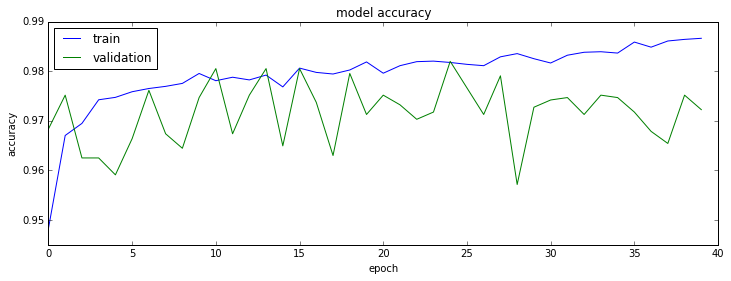

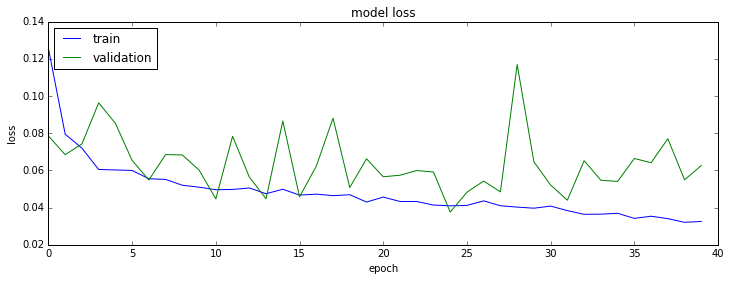

In [15]:
history_plot('acc', 'val_acc', 'model accuracy', 'accuracy', 'epoch')
history_plot('loss', 'val_loss', 'model loss', 'loss', 'epoch')

En la grafica se observa que no hay un ajuste adecuado con la arquitectura evaluada

In [16]:
label_pred=model.predict_classes(data_test)

Confusion Matrix: 
 [[12649    15]
 [  120   212]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.989612188365651
ROC AUC: 0.8186848784905889
------------------------------------------------------------
Precisión por clase: [0.99060224 0.9339207 ]
Sensibilidad - Recall por clase: [0.99881554 0.63855422]
F1 por clase: [0.99469194 0.75849732]
------------------------------------------------------------
F1 Macro: 0.8765946261554878
F1 Micro: 0.989612188365651
F1 Weighted: 0.9886580318944709
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.8186848784905889
Sensibilidad - Recall Micro: 0.989612188365651
Sensibilidad - Recall Weighted: 0.989612188365651
------------------------------------------------------------
Precisión Macro: 0.9622614723226648
Precisión Micro: 0.989612188365651
Precisión Weighted: 0.9891542350592383
------------------------------------------------------------
Verdaderos positivos - True Positives: 212
Verdaderos ne

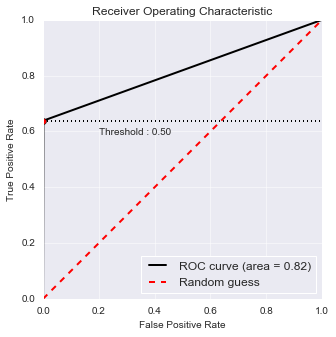

In [17]:
# model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
model_evaluation(data_train, label_train, data_test, label_test, model, label_pred)

In [18]:
# cargar el mejor modelo guardado durante el entrenamiento

from keras.models import load_model
# load the saved model
saved_model = load_model('classification_model.h5')

In [19]:
label_pred2=saved_model.predict_classes(data_test)

Confusion Matrix: 
 [[12636    28]
 [   69   263]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9925361649738381
ROC AUC: 0.8949788414555253
------------------------------------------------------------
Precisión por clase: [0.99456907 0.90378007]
Sensibilidad - Recall por clase: [0.99778901 0.79216867]
F1 por clase: [0.99617644 0.84430177]
------------------------------------------------------------
F1 Macro: 0.9202391007287809
F1 Micro: 0.9925361649738381
F1 Weighted: 0.9922965965883174
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.8949788414555252
Sensibilidad - Recall Micro: 0.9925361649738381
Sensibilidad - Recall Weighted: 0.9925361649738381
------------------------------------------------------------
Precisión Macro: 0.9491745680124312
Precisión Micro: 0.9925361649738381
Precisión Weighted: 0.992249742309843
------------------------------------------------------------
Verdaderos positivos - True Positives: 263
Verdadero

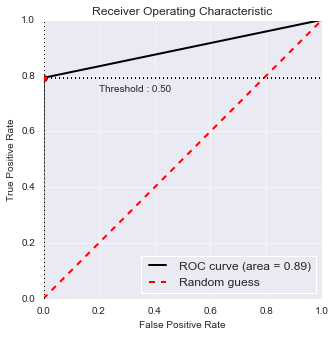

In [20]:
# model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
model_evaluation(data_train, label_train, data_test, label_test, saved_model, label_pred2)

Se obtienen buenos resultados en terminos de F1 macro y Recall macro

In [24]:

n_steps=data_train.shape[1]
n_length= data_train.shape[2]
n_features =data_train.shape[3]
n_outputs= 1

model = Sequential()
model.add(TimeDistributed(Conv1D(256, 3, activation='relu'), input_shape=(None,n_length,n_features)))
model.add(TimeDistributed(Conv1D(256, 3, activation='relu')))
model.add(TimeDistributed(Dropout(0.2)))
model.add(TimeDistributed(MaxPooling1D()))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dense(n_outputs, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# entrenamiento 
history = model.fit(data_train, label_train, epochs=20, batch_size=32, verbose=1)
print(history.history.keys())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_16 (TimeDis (None, None, 8, 256)      18688     
_________________________________________________________________
time_distributed_17 (TimeDis (None, None, 6, 256)      196864    
_________________________________________________________________
time_distributed_18 (TimeDis (None, None, 6, 256)      0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, None, 3, 256)      0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, None, 768)         0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                163800    
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
__________

In [25]:
# evaluar el modelo
_, train_acc = model.evaluate(data_train, label_train, batch_size=32, verbose=1)
_, test_acc = model.evaluate(data_test, label_test, batch_size=32, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

12996/12996 [==============================] - 2s 120us/step
Train: 0.982, Test: 0.992


In [26]:
label_pred=model.predict_classes(data_test)

Confusion Matrix: 
 [[12633    31]
 [   74   258]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9919205909510619
ROC AUC: 0.8873302749849682
------------------------------------------------------------
Precisión por clase: [0.99417644 0.89273356]
Sensibilidad - Recall por clase: [0.99755212 0.77710843]
F1 por clase: [0.99586142 0.83091787]
------------------------------------------------------------
F1 Macro: 0.9133896454870589
F1 Micro: 0.9919205909510619
F1 Weighted: 0.9916477157466212
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.8873302749849683
Sensibilidad - Recall Micro: 0.9919205909510619
Sensibilidad - Recall Weighted: 0.9919205909510619
------------------------------------------------------------
Precisión Macro: 0.9434550010987596
Precisión Micro: 0.9919205909510619
Precisión Weighted: 0.9915849458610878
------------------------------------------------------------
Verdaderos positivos - True Positives: 258
Verdader

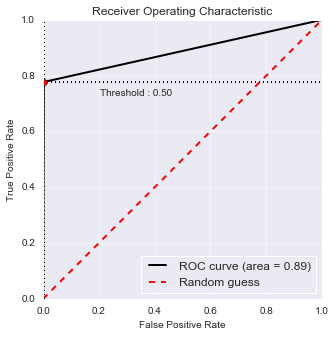

In [27]:
# metricas de desempeño
model_evaluation(data_train, label_train, data_test, label_test, model, label_pred)

## Ajuste avanzado

## Busqueda de numero optimo de numero de filtros en la red CNN-LSTM


>p=32 #1: 99.038
>p=32 #2: 98.715
>p=32 #3: 98.946
>p=64 #1: 99.023
>p=64 #2: 99.069
>p=64 #3: 98.884
>p=128 #1: 99.084
>p=128 #2: 99.023
>p=128 #3: 98.884
>p=256 #1: 99.046
>p=256 #2: 99.161
>p=256 #3: 98.946
>p=512 #1: 99.169
>p=512 #2: 98.653
>p=512 #3: 99.046
[[99.03816558941213, 98.7149892274546, 98.9458294859957], [99.02277623884272, 99.06894429055095, 98.88427208371807], [99.08433364112035, 99.02277623884272, 98.88427208371807], [99.04586026469683, 99.16128039396737, 98.9458294859957], [99.16897506925207, 98.65343182517698, 99.04586026469683]] [32, 64, 128, 256, 512]
Param=32: 98.900% (+/-0.136)
Param=64: 98.992% (+/-0.078)
Param=128: 98.997% (+/-0.084)
Param=256: 99.051% (+/-0.088)
Param=512: 98.956% (+/-0.220)


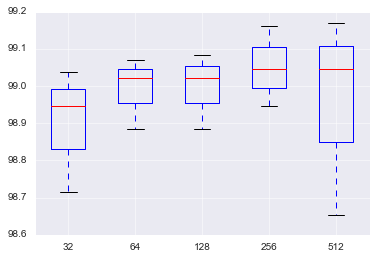

In [22]:
# funcion para entrenar modelo y buscar numero optimo de filtros 
def evaluate_model(data_train, label_train, data_test, label_test, n_filters):
    # definir arquitectura
    verbose, epochs, batch_size = 0, 20, 32
    n_steps=data_train.shape[1]
    n_length= data_train.shape[2]
    n_features =data_train.shape[3]
    n_outputs= 1
    # definir modelo
    model = Sequential()
    model.add(TimeDistributed(Conv1D(n_filters, 3, activation='relu'), input_shape=(None,n_length,n_features)))
    model.add(TimeDistributed(Conv1D(n_filters, 3, activation='relu')))
    model.add(TimeDistributed(Dropout(0.4)))
    model.add(TimeDistributed(MaxPooling1D()))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(100))
    model.add(Dropout(0.4))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # entrenar la red
    model.fit(data_train, label_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluar el modelo
    _, accuracy = model.evaluate(data_test, label_test, batch_size=batch_size, verbose=0)
    return accuracy

# resumen de resultados
def summarize_results(scores, params):
    print(scores, params)
    # media y desviacion estandar
    for i in range(len(scores)):
        m, s = mean(scores[i]), std(scores[i])
        print('Param=%d: %.3f%% (+/-%.3f)' % (params[i], m, s))
    # boxplot 
    pyplot.boxplot(scores, labels=params)
    pyplot.savefig('exp_cnn_filters.png')

# experimentos (3)
def run_experiment(params, repeats=3):
    # evaluar cada parametro
    all_scores = list()
    for p in params:
        # repetir el experimento
        scores = list()
        for r in range(repeats):
            score = evaluate_model(data_train, label_train, data_test, label_test, p)
            score = score * 100.0
            print('>p=%d #%d: %.3f' % (p, r+1, score))
            scores.append(score)
        all_scores.append(scores)
    # resumir resultados de los experimentos
    summarize_results(all_scores, params)

# correr experimento 3 veces por cada parametro
n_params = [32, 64, 128, 256, 512] # numero de filtros que se van a evaluar
run_experiment(n_params)


Si observamos la grafica y resultados, se evidencia que el numero de filtros optimo es 256 ya que presenta la mayor exactitud media con 99.051% y una desviacion estandar de 0.088% 

## Ajuste tamaño del kernel 

>p=2 #1: 99.077
>p=2 #2: 98.661
>p=3 #1: 98.930
>p=3 #2: 98.538
>p=5 #1: 98.892
>p=5 #2: 98.315
[[99.07663896583564, 98.66112650046168], [98.9304401354263, 98.53801169590643], [98.89196675900277, 98.31486611265005]] [2, 3, 5]
Param=2: 98.869% (+/-0.208)
Param=3: 98.734% (+/-0.196)
Param=5: 98.603% (+/-0.289)


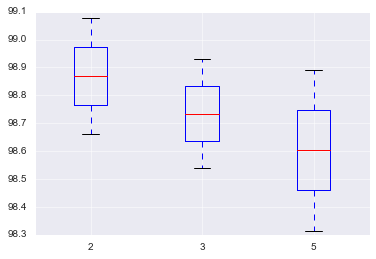

In [24]:
# funcion para entrenar modelo y buscar el tamaño de kernel optimo

def evaluate_model(data_train, label_train, data_test, label_test, n_kernel):
    # definir arquitectura
    verbose, epochs, batch_size = 0, 20, 32
    n_steps=data_train.shape[1]
    n_length= data_train.shape[2]
    n_features =data_train.shape[3]
    n_outputs= 1
    # definir modelo
    model = Sequential()
    model.add(TimeDistributed(Conv1D(256, n_kernel, activation='relu'), input_shape=(None,n_length,n_features)))
    model.add(TimeDistributed(Conv1D(256, n_kernel, activation='relu')))
    model.add(TimeDistributed(Dropout(0.4)))
    model.add(TimeDistributed(MaxPooling1D()))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(100))
    model.add(Dropout(0.4))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # entrenar la red
    model.fit(data_train, label_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluar el modelo
    _, accuracy = model.evaluate(data_test, label_test, batch_size=batch_size, verbose=0)
    return accuracy

# resumen de resultados
def summarize_results(scores, params):
    print(scores, params)
    # media y desviacion estandar
    for i in range(len(scores)):
        m, s = mean(scores[i]), std(scores[i])
        print('Param=%d: %.3f%% (+/-%.3f)' % (params[i], m, s))
    # boxplot 
    pyplot.boxplot(scores, labels=params)
    pyplot.savefig('exp_cnn_kernel.png')

# experimentos (2)
def run_experiment(params, repeats=2):
    # evaluar cada parametro
    all_scores = list()
    for p in params:
        # repetir el experimento
        scores = list()
        for r in range(repeats):
            score = evaluate_model(data_train, label_train, data_test, label_test, p)
            score = score * 100.0
            print('>p=%d #%d: %.3f' % (p, r+1, score))
            scores.append(score)
        all_scores.append(scores)
    # resumir resultados de los experimentos
    summarize_results(all_scores, params)

# correr experimento 2 veces por cada parametro
n_params = [2, 3, 5]
run_experiment(n_params)




El tamaño de kernel =2 entrega la mayor exactitud media 

## Repetir el modelo 5 veces con la arquitectura ajustada

In [25]:

def evaluate_model(data_train, label_train, data_test, label_test):
    # definir modelo
    verbose, epochs, batch_size = 0, 20, 32
    n_steps=data_train.shape[1]
    n_length= data_train.shape[2]
    n_features =data_train.shape[3]
    n_outputs= 1
    
    model = Sequential()
    model.add(TimeDistributed(Conv1D(256, 2, activation='relu'), input_shape=(None,n_length,n_features)))
    model.add(TimeDistributed(Conv1D(256, 2, activation='relu')))
    model.add(TimeDistributed(Dropout(0.4)))
    model.add(TimeDistributed(MaxPooling1D()))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(100))
    model.add(Dropout(0.4))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # entrenar la red
    model.fit(data_train, label_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluar modelo
    _, accuracy = model.evaluate(data_test, label_test, batch_size=batch_size, verbose=0)
    return accuracy

#  scores
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

# correr el experimento 5 veces
def run_experiment(repeats=5):
    # repetir experimento
    scores = list()
    for r in range(repeats):
        score = evaluate_model(data_train, label_train, data_test, label_test)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
    # resumen de resultados
    summarize_results(scores)

# correr experimento
run_experiment()

>#1: 98.553
>#2: 99.184
>#3: 99.184
>#4: 98.792
>#5: 98.984
[98.55340104647584, 99.18436441982148, 99.18436441982148, 98.79193598030163, 98.9843028624192]
Accuracy: 98.940% (+/-0.242)


Se obtiene una exactitu media de 98.94% con una desviacion estandar de 0.242%

## Evaluar modelo

In [36]:
model_path_clf = 'classification_model.h5'  

# modelo
verbose, epochs, batch_size = 0, 50, 32
n_steps=data_train.shape[1]
n_length= data_train.shape[2]
n_features =data_train.shape[3]
n_outputs= 1


model = Sequential()
model.add(TimeDistributed(Conv1D(256, 2, activation='relu'), input_shape=(None,n_length,n_features)))
model.add(TimeDistributed(Conv1D(256, 2, activation='relu')))
model.add(TimeDistributed(Dropout(0.2)))
model.add(TimeDistributed(MaxPooling1D()))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(200, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dense(n_outputs, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# entrenar la red

history = model.fit(data_train, label_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=2, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path_clf, monitor='val_loss', save_best_only=True, mode='min', verbose=2)])
print(history.history.keys())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_198 (TimeDi (None, None, 9, 256)      12544     
_________________________________________________________________
time_distributed_199 (TimeDi (None, None, 8, 256)      131328    
_________________________________________________________________
time_distributed_200 (TimeDi (None, None, 8, 256)      0         
_________________________________________________________________
time_distributed_201 (TimeDi (None, None, 4, 256)      0         
_________________________________________________________________
time_distributed_202 (TimeDi (None, None, 1024)        0         
_________________________________________________________________
lstm_47 (LSTM)               (None, None, 200)         980000    
_________________________________________________________________
dropout_87 (Dropout)         (None, None, 200)         0         
__________

In [37]:
# cargar el mejor modelo guardado durante el entrenamiento

from keras.models import load_model

saved_model = load_model('classification_model.h5')

In [38]:
#evaluate the model
_, train_acc = saved_model.evaluate(data_train, label_train, batch_size=batch_size, verbose=1)
_, test_acc = saved_model.evaluate(data_test, label_test, batch_size=batch_size, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

12996/12996 [==============================] - 5s 365us/step
Train: 0.983, Test: 0.993


In [39]:
label_pred=saved_model.predict_classes(data_test)

Confusion Matrix: 
 [[12633    31]
 [   58   274]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9931517389966144
ROC AUC: 0.911426660527137
------------------------------------------------------------
Precisión por clase: [0.99542983 0.89836066]
Sensibilidad - Recall por clase: [0.99755212 0.8253012 ]
F1 por clase: [0.99648984 0.86028257]
------------------------------------------------------------
F1 Macro: 0.928386209390238
F1 Micro: 0.9931517389966144
F1 Weighted: 0.9930102494505854
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.9114266605271371
Sensibilidad - Recall Micro: 0.9931517389966144
Sensibilidad - Recall Weighted: 0.9931517389966144
------------------------------------------------------------
Precisión Macro: 0.9468952439511156
Precisión Micro: 0.9931517389966144
Precisión Weighted: 0.9929500717325697
------------------------------------------------------------
Verdaderos positivos - True Positives: 274
Verdaderos

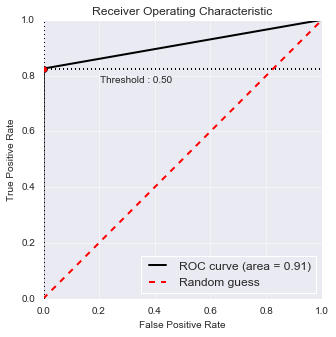

In [40]:
# metricas de desempeño:
model_evaluation(data_train, label_train, data_test, label_test, saved_model, label_pred)

In [55]:
# repetir modelo 5 veces y evaluar exactitud
def evaluate_model(data_train, label_train, data_test, label_test):
    # define model
    verbose, epochs, batch_size = 0, 20, 32
    n_steps=data_train.shape[1]
    n_length= data_train.shape[2]
    n_features =data_train.shape[3]
    n_outputs= 1
    # define model
    model = Sequential()
    model.add(TimeDistributed(Conv1D(256, 2, activation='relu'), input_shape=(None,n_length,n_features)))
    model.add(TimeDistributed(Conv1D(256, 2, activation='relu')))
    model.add(TimeDistributed(Dropout(0.2)))
    model.add(TimeDistributed(MaxPooling1D()))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(200, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(data_train, label_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(data_test, label_test, batch_size=batch_size, verbose=0)
    return accuracy

# summarize scores
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

# run an experiment
def run_experiment(repeats=5):
    # repeat experiment
    scores = list()
    for r in range(repeats):
        score = evaluate_model(data_train, label_train, data_test, label_test)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
    # summarize results
    summarize_results(scores)

# run the experiment
run_experiment()

>#1: 99.138
>#2: 99.054
>#3: 99.277
>#4: 99.300
>#5: 98.800
[99.13819636811326, 99.05355493998154, 99.27670052323792, 99.29978454909202, 98.79963065558634]
Accuracy: 99.114% (+/-0.181)


## Arquitectura CNN-LSTM optima con ajuste de pesos de clases

In [14]:
from keras import regularizers

model_path_clf = 'classification_modelcnnlstm.h5'  

# model
verbose, epochs, batch_size = 0, 50, 64
n_steps=data_train.shape[1]
n_length= data_train.shape[2]
n_features =data_train.shape[3]
n_outputs= 1
weight = [{0:1,1:5}]

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(256, 2, activation='relu'), input_shape=(None,n_length,n_features)))
model.add(TimeDistributed(Conv1D(256, 2, activation='relu')))
model.add(TimeDistributed(Dropout(0.2)))
model.add(TimeDistributed(MaxPooling1D()))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(70, return_sequences=True, kernel_initializer='glorot_normal'))
model.add(Dropout(0.4))
model.add(LSTM(30,kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01), return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(50, activation='sigmoid'))
model.add(Dense(n_outputs, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# fit network

history = model.fit(data_train, label_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=2, class_weight=weight,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=2, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path_clf, monitor='val_loss', save_best_only=True, mode='min', verbose=2)])
print(history.history.keys())







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, None, 9, 256)      12544     
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 8, 256)      131328    
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 8, 256)      0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 4, 256)      0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 1024)        0         
__________________________________________________________

In [15]:
# cargar el mejor modelo guardado durante el entrenamiento

from keras.models import load_model

saved_model = load_model('classification_modelcnnlstm.h5')

In [16]:
# evaluar modelo
_, train_acc = saved_model.evaluate(data_train, label_train, batch_size=batch_size, verbose=1)
_, test_acc = saved_model.evaluate(data_test, label_test, batch_size=batch_size, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

12996/12996 [==============================] - 1s 90us/step
Train: 0.980, Test: 0.991


In [17]:
label_pred=saved_model.predict_classes(data_test)

Confusion Matrix: 
 [[12575    89]
 [   32   300]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9906894429055094
ROC AUC: 0.9482933312529969
------------------------------------------------------------
Precisión por clase: [0.99746173 0.77120823]
Sensibilidad - Recall por clase: [0.9929722  0.90361446]
F1 por clase: [0.9952119  0.83217753]
------------------------------------------------------------
F1 Macro: 0.9136947170892216
F1 Micro: 0.9906894429055094
F1 Weighted: 0.9910469744225382
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.9482933312529969
Sensibilidad - Recall Micro: 0.9906894429055094
Sensibilidad - Recall Weighted: 0.9906894429055094
------------------------------------------------------------
Precisión Macro: 0.884334976916362
Precisión Micro: 0.9906894429055094
Precisión Weighted: 0.991681782823889
------------------------------------------------------------
Verdaderos positivos - True Positives: 300
Verdaderos

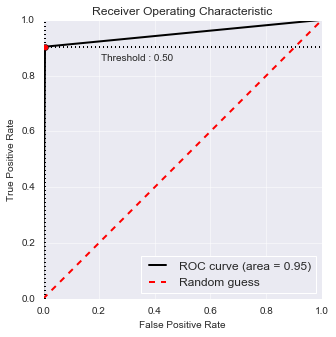

In [18]:
# metricas de desempeño
model_evaluation(data_train, label_train, data_test, label_test, saved_model, label_pred)

<module 'matplotlib.pyplot' from 'C:\\Users\\alexh\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

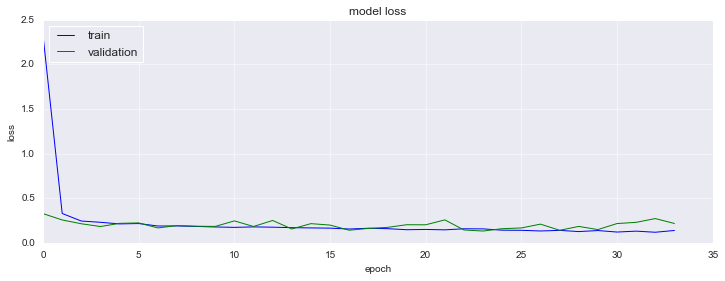

In [19]:
history_plot('loss', 'val_loss', 'model loss', 'loss', 'epoch')

Se evidencia un buen ajuste, es un caso en el que el rendimiento del modelo es bueno tanto en el train como en los conjuntos de validación.

Esto se puede diagnosticar a partir de una trama donde el train y la pérdida de validación disminuyen y se estabilizan alrededor del mismo punto.

## Modelo seleccionado

In [21]:
from keras import regularizers

model_path_clf = 'classification_modelcnnlstm.h5'  

# modelo
verbose, epochs, batch_size = 0, 50, 64
n_steps=data_train.shape[1]
n_length= data_train.shape[2]
n_features =data_train.shape[3]
n_outputs= 1
weight = [{0:1,1:5}]


model = Sequential()
model.add(TimeDistributed(Conv1D(256, 2, activation='relu'), input_shape=(None,n_length,n_features)))
model.add(TimeDistributed(Conv1D(256, 2, activation='relu')))
model.add(TimeDistributed(Dropout(0.2)))
model.add(TimeDistributed(MaxPooling1D()))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(70, return_sequences=True, kernel_initializer='glorot_normal'))
model.add(Dropout(0.4))
model.add(LSTM(30,kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01), return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(20, activation='sigmoid'))
model.add(Dense(n_outputs, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# fit network

history = model.fit(data_train, label_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=2, class_weight=weight,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=2, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path_clf, monitor='val_loss', save_best_only=True, mode='min', verbose=2)])
print(history.history.keys())



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_11 (TimeDis (None, None, 9, 256)      12544     
_________________________________________________________________
time_distributed_12 (TimeDis (None, None, 8, 256)      131328    
_________________________________________________________________
time_distributed_13 (TimeDis (None, None, 8, 256)      0         
_________________________________________________________________
time_distributed_14 (TimeDis (None, None, 4, 256)      0         
_________________________________________________________________
time_distributed_15 (TimeDis (None, None, 1024)        0         
_________________________________________________________________
lstm_5 (LSTM)                (None, None, 70)          306600    
_________________________________________________________________
dropout_8 (Dropout)          (None, None, 70)          0         
__________

In [22]:
# cargar el mejor modelo guardado durante el entrenamiento

from keras.models import load_model

saved_model = load_model('classification_modelcnnlstm.h5')

In [23]:
# evaluar modelo en train y test
_, train_acc = saved_model.evaluate(data_train, label_train, batch_size=batch_size, verbose=1)
_, test_acc = saved_model.evaluate(data_test, label_test, batch_size=batch_size, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

12996/12996 [==============================] - 1s 97us/step
Train: 0.975, Test: 0.992


In [24]:
label_pred=saved_model.predict_classes(data_test)

Confusion Matrix: 
 [[12592    72]
 [   28   304]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.992305324715297
ROC AUC: 0.9549886215741044
------------------------------------------------------------
Precisión por clase: [0.9977813  0.80851064]
Sensibilidad - Recall por clase: [0.99431459 0.91566265]
F1 por clase: [0.99604493 0.85875706]
------------------------------------------------------------
F1 Macro: 0.9274009958733198
F1 Micro: 0.992305324715297
F1 Weighted: 0.9925377295386244
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.9549886215741044
Sensibilidad - Recall Micro: 0.992305324715297
Sensibilidad - Recall Weighted: 0.992305324715297
------------------------------------------------------------
Precisión Macro: 0.9031459689112182
Precisión Micro: 0.992305324715297
Precisión Weighted: 0.9929461302780838
------------------------------------------------------------
Verdaderos positivos - True Positives: 304
Verdaderos ne

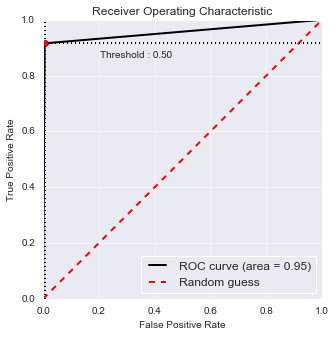

In [25]:
# metricas de desempeño
model_evaluation(data_train, label_train, data_test, label_test, saved_model, label_pred)

<module 'matplotlib.pyplot' from 'C:\\Users\\alexh\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

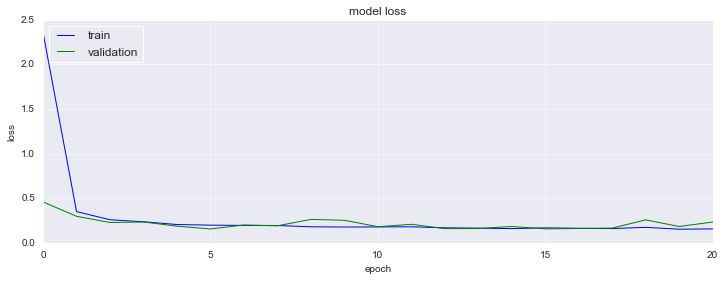

In [26]:
history_plot('loss', 'val_loss', 'model loss', 'loss', 'epoch')

Se obtiene el mayor F1 macro y recall macro de los experimentos, ademas se evidencia un ajuste adecuado de la curva de aprendizaje

* La red CNN-LSTM obtiene el mejor F1- Score macro con 93%, es decir 2 puntos porcentuales por encima de la red neuronal LSTM de varias capas y 8 puntos porcentuales por encima de los algoritmos de conjunto de Machine Learning clasicos que se analizaron, este resultado se logra debido al balance entre las medidas macro del Recall y la precision, las cuales obtuvieron valores de 95% y 90% respectivamente.

* Partiendo del hecho que la clase 1 (falla potencial) es la de mayor importancia, con la red CNN-LSTM se obtiene la medida de Recall con un valor del 92% para la clase 1, esta medida es de alta relevancia ya que uno de los objetivos en la clasicacion de fallas es minimizar el numero de falsos negativos, en la matriz de confusion del modelo CNN-LSTM, se observa que el numero de observaciones clasificadas como falsos negativos es de 28 frente a 304 observaciones clasificadas como verdaderos positivos que corresponde a fallas funcionales clasificadas correctamente por la red neuronal hibrida.

* El nivel de precision de la clase mayoritaria etiquetada como clase 0 es del 99.78%, es decir que el modelo detecta con una excelente precision las observaciones etiquetadas como estado funcional o normal de la maquina. se obtienen de la base de entrenamiento un total de 12.592 observaciones clasificadas como verdaderos negativos, ademas 72 falsos positivos que para este caso hacen referencia a observaciones clasificadas como falla de la maquina, cuando realmente son observaciones de estado funcional del activo fisico.

* Con la red CNN-LSTM se obtiene el mayor valor del ROC-AUC que registra un 95%.

* Cuando se evalua la curva de aprendizaje del modelo hibrido CNN-LSTM, se corrobora que el desempeño de la red presenta un ajuste adecuado, puesto que tanto la perdida del conjunto de entrenamiento como la de validacion disminuyen y se estabilizan alrededor del mismo punto; en este caso se configura en la red neuronal una funcion de parada temprana para detener el entrenamiento como medida de regularizacion para evitar el sobreajuste.